In [1]:
# # Enable remote debugging
# import debugpy
# import os

# # Only enable debugging if not already enabled
# if not debugpy.is_client_connected():
#     debugpy.listen(("localhost", 5678))
#     print("Waiting for debugger to attach...")
#     debugpy.wait_for_client()
#     print("Debugger attached!")

In [2]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool


import gradio as gr
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os
from agent_utils import GraphAgent
import pprint



[13:22:43 -0600] [INFO]: NetworkX-cuGraph is unavailable: No module named 'nx_cugraph'.


In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '10010034', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010038', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8010233', 'name': 'plays', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '10010033', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010040', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010036', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8010231', 'name': 'Users', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '10010035', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010039', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10010037', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8010232', 'name': 'Games', 'system': F

In [6]:

G_adb = nxadb.Graph(name="SteamGraph", db=db)

print(G_adb)

[13:22:47 -0600] [INFO]: Graph 'SteamGraph' exists.
[13:22:48 -0600] [INFO]: Default node type set to 'Games'


Graph named 'SteamGraph' with 14950 nodes and 70477 edges


In [7]:
graph_def = db.collection("_graphs").get("SteamGraph")
print(graph_def)


{'_key': 'SteamGraph', '_id': '_graphs/SteamGraph', '_rev': '_jTKnPCu---', 'numberOfShards': 1, 'replicationFactor': 3, 'minReplicationFactor': 1, 'writeConcern': 1, 'isSmart': False, 'isSatellite': False, 'edgeDefinitions': [{'collection': 'plays', 'from': ['Users'], 'to': ['Games']}], 'orphanCollections': [], 'networkx': {'name': 'SteamGraph'}}


In [8]:
for node, data in list(G_adb.nodes(data=True))[:10]:
    print(node, data.get("_id"))


Users/45016429 Users/45016429
Users/58967365 Users/58967365
Users/186194652 Users/186194652
Users/264125600 Users/264125600
Users/203370502 Users/203370502
Games/14074_a_r_e_s_extinction_agenda_ex Games/14074_a_r_e_s_extinction_agenda_ex
Users/91486768 Users/91486768
Users/303300985 Users/303300985
Users/252369207 Users/252369207
Users/307688442 Users/307688442


In [9]:
print(G_adb)

Graph named 'SteamGraph' with 14950 nodes and 70477 edges


### AQL Test

In [10]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('SteamGraph')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
Games
_analyzers
_graphs
_apps
_frontend
plays
Users
_queues
_aqlfunctions
_appbundles
_jobs

Graph collections:
[{'edge_collection': 'plays', 'from_vertex_collections': ['Users'], 'to_vertex_collections': ['Games']}]


In [11]:


# -----------------------------------------------------------
# 1. Query 3 random nodes from the Users collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR node IN Users
        SORT RAND()
        LIMIT 3
        RETURN node
""")
print("Sample Users Nodes:")
for node in result_cursor:
    print(node)
print('-'*10)

# -----------------------------------------------------------
# 2. Query 3 random edges from the plays edge collection.
# -----------------------------------------------------------
result_cursor = G_adb.query("""
    FOR edge IN plays
        SORT RAND()
        LIMIT 3
        RETURN edge
""")
print("Sample Plays Edges:")
for edge in result_cursor:
    print(edge)
print('-'*10)


Sample Users Nodes:
{'_key': '30061970', '_id': 'Users/30061970', '_rev': '_jSs4caC--A', 'type': 'Users', 'steamid': 30061970, 'connected_communities': [1, 4, 47, 17, 18, 20, 21, 52, 27, 31]}
{'_key': '216924034', '_id': 'Users/216924034', '_rev': '_jSrlEiy-_l', 'type': 'Users', 'steamid': 216924034}
{'_key': '156493428', '_id': 'Users/156493428', '_rev': '_jSrlEh6--A', 'type': 'Users', 'steamid': 156493428}
----------
Sample Plays Edges:
{'_key': '26951', '_id': 'plays/26951', '_from': 'Users/127890922', '_to': 'Games/11371_dota_2', '_rev': '_jSrlMQu--G', 'weight': 0.1}
{'_key': '56817', '_id': 'plays/56817', '_from': 'Users/216500614', '_to': 'Games/11389_counter_strike_global_offensive', '_rev': '_jSrlOtW--Y', 'weight': 348}
{'_key': '6393', '_id': 'plays/6393', '_from': 'Users/132180557', '_to': 'Games/11389_counter_strike_global_offensive', '_rev': '_jSrlLFK--n', 'weight': 9.6}
----------


### Agent

In [12]:
arango_graph = ArangoGraph(db)


In [13]:
# If the schema is exposed as an attribute
graph_schema = arango_graph.schema
pprint.pprint(graph_schema)


{'Collection Schema': [{'collection_name': 'Games',
                        'collection_type': 'document',
                        'document_properties': [{'name': '_key', 'type': 'str'},
                                                {'name': '_id', 'type': 'str'},
                                                {'name': '_rev', 'type': 'str'},
                                                {'name': 'type', 'type': 'str'},
                                                {'name': 'GameName',
                                                 'type': 'str'}],
                        'example_document': {'GameName': 'The Elder Scrolls V '
                                                         'Skyrim',
                                             '_id': 'Games/11350_the_elder_scrolls_v_skyrim',
                                             '_key': '11350_the_elder_scrolls_v_skyrim',
                                             '_rev': '_jSrlFhq---',
                                     

In [14]:
result_cursor =  G_adb.query("""
WITH Games, plays
FOR game IN Games 
  LET playerCount = (
    FOR play IN plays 
    FILTER play._to == game._id 
    COLLECT WITH COUNT INTO length 
    RETURN length
  )[0] 
  SORT playerCount DESC 
  LIMIT 1 
  RETURN {game, playerCount: playerCount}
""")

for item in result_cursor:
    print(item)
print('-'*10)



{'game': {'_key': '11371_dota_2', '_id': 'Games/11371_dota_2', '_rev': '_jSrlFhu--F', 'type': 'Games', 'GameName': 'Dota 2'}, 'playerCount': 4841}
----------


In [15]:
arango_graph

/home/manoj99/miniconda3/envs/Arrongo/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


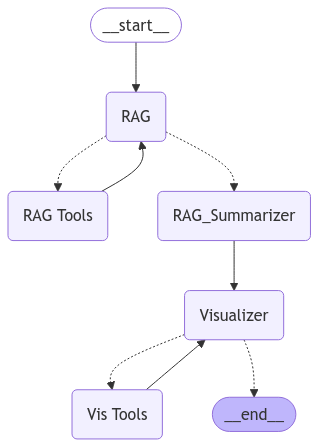

In [16]:
agent = GraphAgent(arango_graph, G_adb)


In [17]:
def create_gradio_interface(agent):
    # ... (keep get_sample_data and display_response functions the same)
    def get_sample_data():
        # Get sample user IDs
        user_cursor = G_adb.query("""
        FOR user IN Users
        SORT RAND()
        LIMIT 5
        RETURN user._id
        """)
        sample_users = [user for user in user_cursor]

        # Get top games by player count
        games_cursor = G_adb.query("""
        WITH Games, plays
        FOR game IN Games
        LET playerCount = (
            FOR play IN plays 
            FILTER play._to == game._id 
            COLLECT WITH COUNT INTO length 
            RETURN length
        )[0]
        SORT playerCount DESC
        LIMIT 5
        RETURN game.GameName
        """)
        sample_games = [game for game in games_cursor]

        return sample_users, sample_games

    def display_response(input_text):
        result = agent.query_graph(input_text)
        print("Inside interface")
        print(result["html_code"])
        return (
            result["html_code"],
            result["rag_reply"]
        )
    
    # Get sample data from graph
    sample_users, sample_games = get_sample_data()
    css = """
         /* Reset any Gradio margins/padding */
        .gradio-container {
            margin: 0 !important;
            padding: 0 !important;
        }
        
        /* Main visualization container */
        #visualization-container {
            width: 100% !important;
            height: 1000px !important;
            margin: 0;
            padding: 0;
            overflow: hidden;
            position: relative;
        }
        
        /* Target the iframe directly */
        #visualization-container iframe {
            width: 100% !important;
            height: 100% !important;
            border: none !important;
            margin: 0 !important;
            padding: 0 !important;
            position: absolute !important;
            top: 0 !important;
            left: 0 !important;
        }

        /* Ensure the column takes full width */
        .svelte-1lyxibv {
            max-width: none !important;
        }
    """
    
    
    with gr.Blocks(css=css) as interface:
        gr.Markdown("# Graph Analysis Interface")
         
        with gr.Row():
            with gr.Column(scale=2):
                input_text = gr.Textbox(
                    label="Query",
                    placeholder="Enter your graph query here...",
                    lines=2
                )
                submit_btn = gr.Button("Analyze", variant="primary")
            
            # Sample IDs panel
            with gr.Column(scale=1):
                with gr.Column(elem_classes=["sample-panel"]):
                    # Format the sample data into markdown
                    users_md = "\n".join([f"- {user}" for user in sample_users])
                    games_md = "\n".join([f"- {game}" for game in sample_games])
                    
                    gr.Markdown(f"""
                    ### Sample User IDs
                    {users_md}

                    ### Popular Games
                    {games_md}
                    """)
        
        with gr.Column():
            text_output = gr.Textbox(
                label="Analysis Result", 
                lines=3
            )
            
            html_output = gr.HTML(
                label="Visualization",
                value="",
                elem_id="visualization-container",
                container=False,
            )
            
        submit_btn.click(
            fn=display_response,
            inputs=[input_text],
            outputs=[html_output, text_output]
        )
    
    return interface

In [18]:
# Assuming G_adb is already defined and is a NetworkX Graph object
import networkx as nx

# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(G_adb)

# Filter out the game nodes
game_nodes = [node for node, data in G_adb.nodes(data=True) if data.get('type') == 'Games']

# Get the game with the highest degree centrality
most_influential_game = max(game_nodes, key=lambda node: degree_centrality.get(node, 0))

# Retrieve the node data for the most influential game
FINAL_RESULT = G_adb.nodes[most_influential_game]

[13:22:56 -0600] [INFO]: Graph 'SteamGraph' load took 3.297522783279419s


In [19]:
interface = create_gradio_interface(agent)
interface.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



Processing Agent State:
[ HumanMessage(content='Analyze the relationship between playtime intensity and gaming diversity, then visualize the clusters', additional_kwargs={}, response_metadata={}, id='71e49f7a-fb52-4acb-991e-d664e4101d60')]

==== RAG PROMPT ====
SYSTEM: You are a Graph Analysis Planner. Follow these steps:
                ANALYSIS APPROACH:
                1. First examine the query complexity and data dependencies
                2. ALWAYS check existing state data before making new tool calls
                3. Choose the optimal strategy:
                   → For simple, direct queries: Use single comprehensive tool calls
                   → For complex analysis: Break down into logical steps
                   → For uncertain data: Start with exploratory queries, then refine
                4. Combine results and formulate a final answer for the query
                5. if the data is not what you want or it is empty; you are allowed to make new tool calls to repl

/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:205: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  aql_generation_chain = LLMChain(llm=llm, prompt=aql_generation_prompt)
/mnt/mydisk/Projects/ArangoGraphRag/ArangoGraphDirectChain.py:257: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  aql_generation_output = self.aql_generation_chain.run(


AQL tool query
FOR user IN Users
    LET totalPlaytime = SUM(
        FOR play IN plays
            FILTER play._from == user._id
            RETURN play.weight
    )
    LET gameCount = COUNT(
        FOR play IN plays
            FILTER play._from == user._id
            RETURN DISTINCT play._to
    )
    RETURN {user_id: user._id, totalPlaytime, gameCount}


> Entering new ArangoGraphDirectChain chain...
Complete AQL Generation Prompt with all values:
--------------------------------------------------------------------------------
Task: Generate an ArangoDB Query Language (AQL) query from a User Input.

You are an ArangoDB Query Language (AQL) expert responsible for translating a `User Input` into an ArangoDB Query Language (AQL) query.

You are given an `ArangoDB Schema`. It is a JSON Object containing:
1. `Graph Schema`: Lists all Graphs within the ArangoDB Database Instance, along with their Edge Relationships.
2. `Collection Schema`: Lists all Collections within the ArangoDB Dat

Traceback (most recent call last):
  File "/mnt/mydisk/Projects/ArangoGraphRag/agent_utils.py", line 376, in text_to_nx_algorithm
    exec(text_to_nx_cleaned, context)
  File "<string>", line 2, in <module>
ModuleNotFoundError: No module named 'sklearn'



RAG_Summarizer State:
[ HumanMessage(content='Analyze the relationship between playtime intensity and gaming diversity, then visualize the clusters', additional_kwargs={}, response_metadata={}, id='71e49f7a-fb52-4acb-991e-d664e4101d60'),
  AIMessage(content="To analyze the relationship between playtime intensity and gaming diversity, we need to follow these steps:\n\n1. **Define Playtime Intensity**: This can be measured by the total playtime a user has across all games. We will need to calculate the total playtime for each user.\n\n2. **Define Gaming Diversity**: This can be measured by the number of different games a user has played. We will need to count the distinct games each user has played.\n\n3. **Data Retrieval**:\n   - Retrieve the playtime data for each user across all games.\n   - Retrieve the number of distinct games each user has played.\n\n4. **Cluster Analysis**:\n   - Use the retrieved data to perform a cluster analysis to identify patterns or groups of users based on

[14:13:30 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[14:13:32 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[14:13:32 -0600] [WARNING]: Database environment variables not set. Can't connect to the database
[14:13:32 -0600] [WARNING]: Database environment variables not set. Can't connect to the database


Converted FINAL_RESULT to serializable format
----------
FINAL_RESULT: {'num_communities': 65, 'all_communities': [{'community_id': 21, 'size': 4026, 'composition': {'Users': 3915, 'Games': 111}, 'nodes': [{'data': {'_id': 'Users/184648711', '_key': '184648711', 'steamid': 184648711, 'type': 'Users'}}, {'data': {'_id': 'Users/127541532', '_key': '127541532', 'steamid': 127541532, 'type': 'Users'}}, {'data': {'_id': 'Users/89623082', '_key': '89623082', 'steamid': 89623082, 'type': 'Users'}}, {'data': {'_id': 'Users/240322275', '_key': '240322275', 'steamid': 240322275, 'type': 'Users'}}, {'data': {'_id': 'Users/197293813', '_key': '197293813', 'steamid': 197293813, 'type': 'Users'}}, {'data': {'_id': 'Users/129177552', '_key': '129177552', 'steamid': 129177552, 'type': 'Users'}}, {'data': {'_id': 'Users/145672760', '_key': '145672760', 'steamid': 145672760, 'type': 'Users'}}, {'data': {'_id': 'Users/223829418', '_key': '223829418', 'steamid': 223829418, 'type': 'Users'}}, {'data': {'_i